<a href="https://colab.research.google.com/github/snaiws/MusicVAE/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA

## import

In [150]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import math
import os
import sys
import time
import music21

In [2]:
# data load
train = tfds.load(
    name="groove/full-midionly",
    split=tfds.Split.TRAIN,
    try_gcs=True)
test = tfds.load(
    name="groove/full-midionly",
    split=tfds.Split.TEST,
    try_gcs=True)
val = tfds.load(
    name="groove/full-midionly",
    split=tfds.Split.VALIDATION,
    try_gcs=True)

In [ ]:
len(train),len(val),len(test)

(897, 124, 129)

## EDA

In [3]:
# meta data
EDA_dataset = train.shuffle(1024).batch(1).prefetch(
    tf.data.experimental.AUTOTUNE)
df_meta = []
midis = []
for features in EDA_dataset.take(len(EDA_dataset)):
  temp = []
  temp.append(features["id"].numpy()[0].decode('utf-8'))
  temp.append(features["drummer"].numpy()[0])
  temp.append(features["style"]["primary"].numpy()[0])
  temp.append(features["style"]["secondary"].numpy()[0].decode('utf-8'))
  temp.append(features["bpm"].numpy()[0])
  temp.append(features["time_signature"].numpy()[0])
  df_meta.append(temp)
  midi = features["midi"].numpy()[0]
  midi = music21.converter.parse(midi)
  midis.append(list(midi.recurse()))
df_meta = pd.DataFrame(df_meta,columns=['id','drummer','style_primary','style_secondary','bpm','time_signature'])

In [ ]:
df_meta.head()

,id,drummer,style_primary,style_secondary,bpm,time_signature
0,drummer1/session2/177,0,1,rhumba,110,1
1,drummer7/session2/6,6,16,,120,1
2,drummer4/session1/9,3,10,merengue,158,1
3,drummer1/session2/108,0,5,rock,92,1
4,drummer7/session1/19,6,8,,100,1


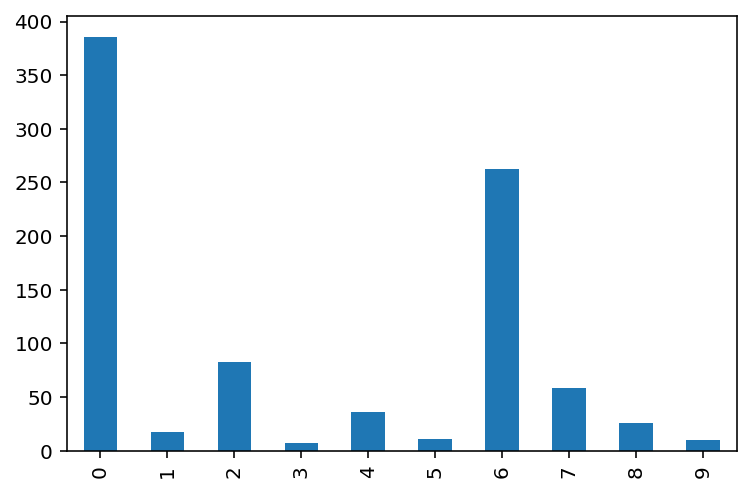

In [ ]:
df_meta['drummer'].sort_values().value_counts(sort=False).plot(kind='bar',x='drummer')

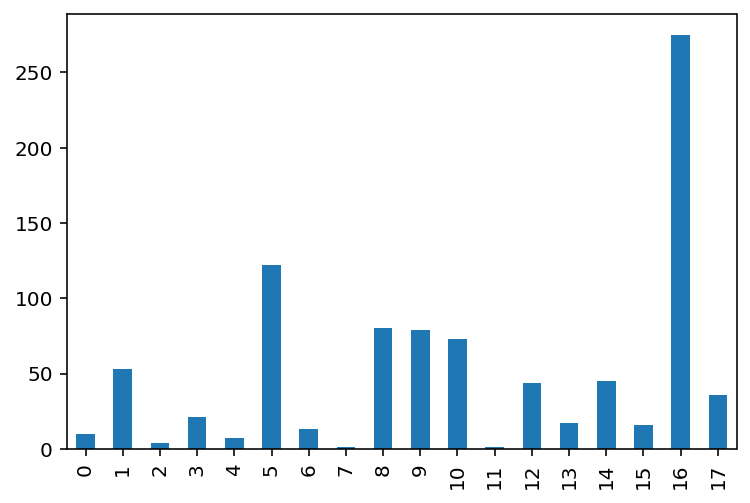

In [ ]:
df_meta['style_primary'].sort_values().value_counts(sort=False).plot(kind='bar',x='style_primary')

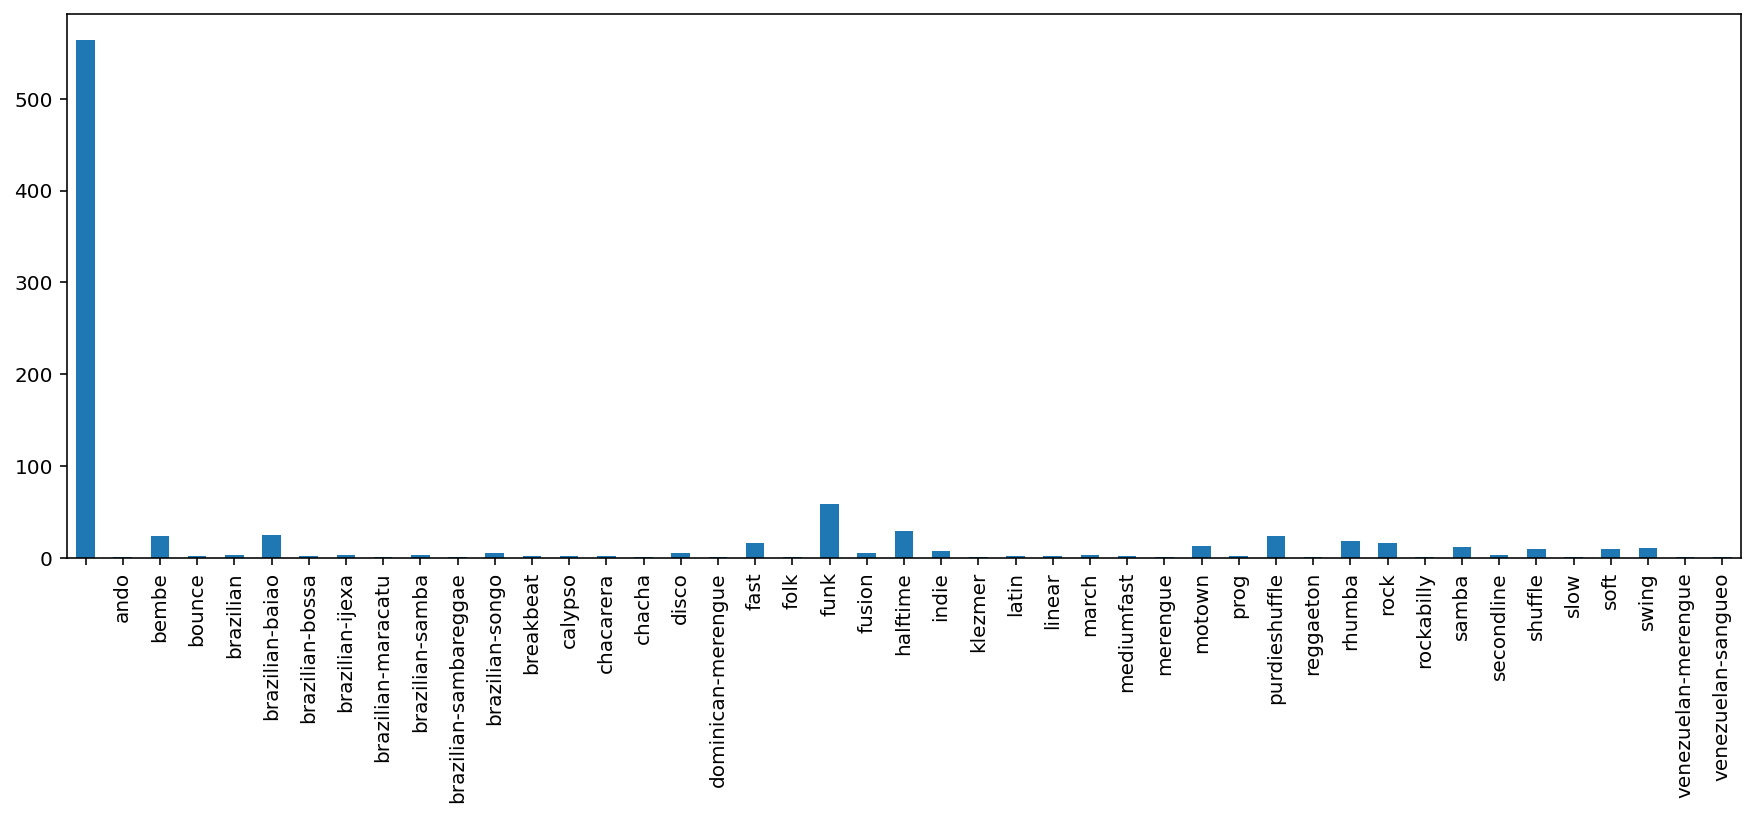

In [ ]:
df_meta['style_secondary'].sort_values().value_counts(sort=False).plot(kind='bar',x='style_secondary',figsize=(15,5))

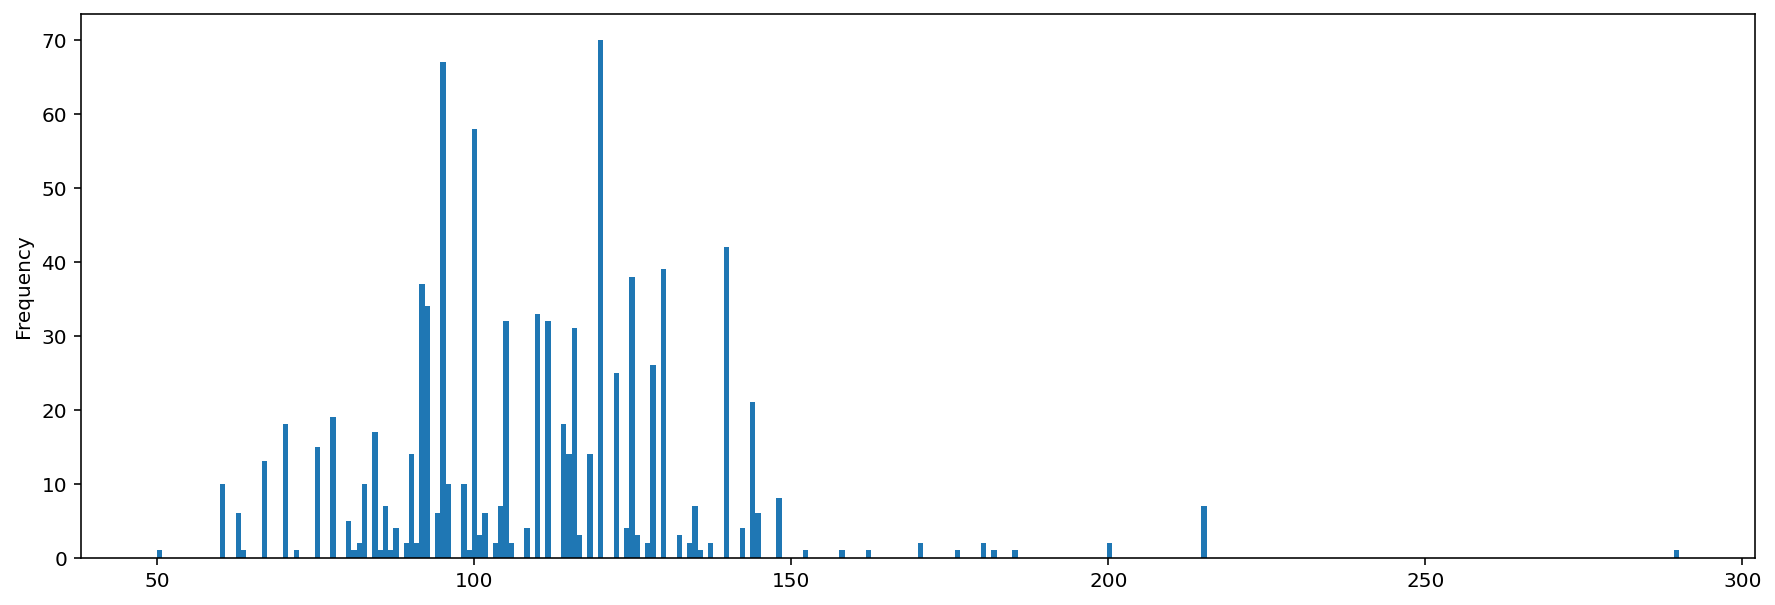

In [ ]:
df_meta['bpm'].plot(kind='hist',bins=df_meta['bpm'].max(),x='bpm',figsize=(15,5))

In [ ]:
df_meta['time_signature'].sort_values().value_counts(sort=False)

0      4
1    887
2      1
3      1
4      4
Name: time_signature, dtype: int64

In [4]:
rests=[]
notes=[]
chords=[]
etc=[]
for midi in midis:
  for obj in midi:
    try:
      if obj.isChord:
        chords.append([obj.volume,obj.seconds, obj.offset, obj.fullName, obj.duration, obj.beat, obj.beatDuration])
      elif obj.isNote:
        notes.append([obj.volume,obj.seconds, obj.offset, obj.fullName, obj.duration, obj.beat, obj.beatDuration])
      elif obj.isRest:
        rests.append([obj.seconds, obj.offset, obj.fullName, obj.duration, obj.beat, obj.beatDuration])
      else:
        etc.append(obj)
    except:
      etc.append(obj)
rests = pd.DataFrame(rests,columns=['seconds','offset','fullName','duration','beat','beatDuration'])
notes = pd.DataFrame(notes,columns=['volume','seconds','offset','fullName','duration','beat','beatDuration'])
chords = pd.DataFrame(chords,columns=['volume','seconds','offset','fullName','duration','beat','beatDuration'])

In [ ]:
uniq=[]
for i in etc:
 if str(i)[0]!='<':
   uniq.append(str(i))
print(list(set(uniq)))

['C major', 'Piano']


모든 악보가 C장조이고, 의미 불명의 피아노가 섞여있습니다.

In [ ]:
for i,j in enumerate(etc):
  if str(j)[0]=='<':
    print(j)
  if i>20:
    break

<music21.stream.Part 0x7f2a6e561c50>
<music21.tempo.MetronomeMark allegretto Quarter=110.0>
<music21.meter.TimeSignature 4/4>
<music21.stream.Part 0x7f2a6dcd71d0>
<music21.tempo.MetronomeMark animato Quarter=120.0>
<music21.meter.TimeSignature 4/4>
<music21.stream.Voice 0x7f2a8207ee90>
<music21.stream.Voice 0x7f2af007b890>
<music21.stream.Part 0x7f2a4a933f10>
<music21.tempo.MetronomeMark vivace Quarter=158.0>
<music21.meter.TimeSignature 4/4>
<music21.stream.Voice 0x7f2a4464eed0>
<music21.stream.Voice 0x7f2a4464e5d0>
<music21.stream.Part 0x7f2a445b7fd0>
<music21.tempo.MetronomeMark moderate Quarter=92.0>
<music21.meter.TimeSignature 4/4>
<music21.stream.Part 0x7f2a44709610>
<music21.tempo.MetronomeMark Quarter=100.0>


악보마다 파트, 템포, 키, 박자를 가집니다.

In [88]:
for i,j in enumerate(etc):
  if str(j)[0]=='<':
    if str(j).split('.')[1]=='meter':
      if str(j).split('.')[-1]!='TimeSignature 4/4>':
        print(j)

<music21.meter.TimeSignature 3/4>
<music21.meter.TimeSignature 3/4>
<music21.meter.TimeSignature 6/8>
<music21.meter.TimeSignature 6/8>
<music21.meter.TimeSignature 3/4>
<music21.meter.TimeSignature 5/8>
<music21.meter.TimeSignature 3/4>
<music21.meter.TimeSignature 6/8>
<music21.meter.TimeSignature 5/4>
<music21.meter.TimeSignature 6/8>


4/4박자를 제외한 악보는 드랍해야겠습니다.

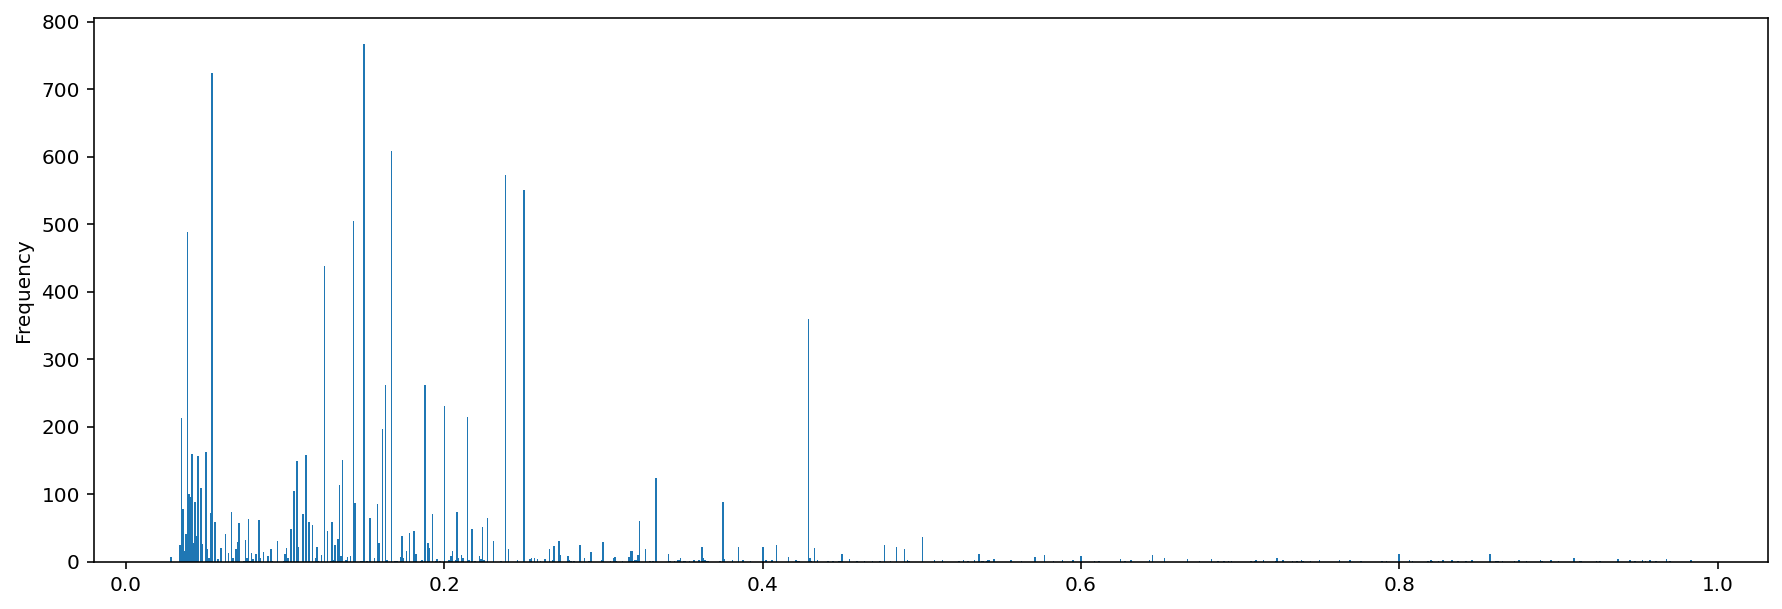

In [ ]:
rests['seconds'][rests['seconds']<1].plot(kind='hist',bins=1000,x='seconds',figsize=(15,5))

In [ ]:
rests['seconds'][rests['seconds']>1].sort_values().value_counts(sort=False)

1.016949       3
1.018519       1
1.021505       1
1.024590       1
1.029412       1
              ..
579.448819     1
599.370079     1
901.176471     1
1031.029412    1
1390.954545    1
Name: seconds, Length: 557, dtype: int64

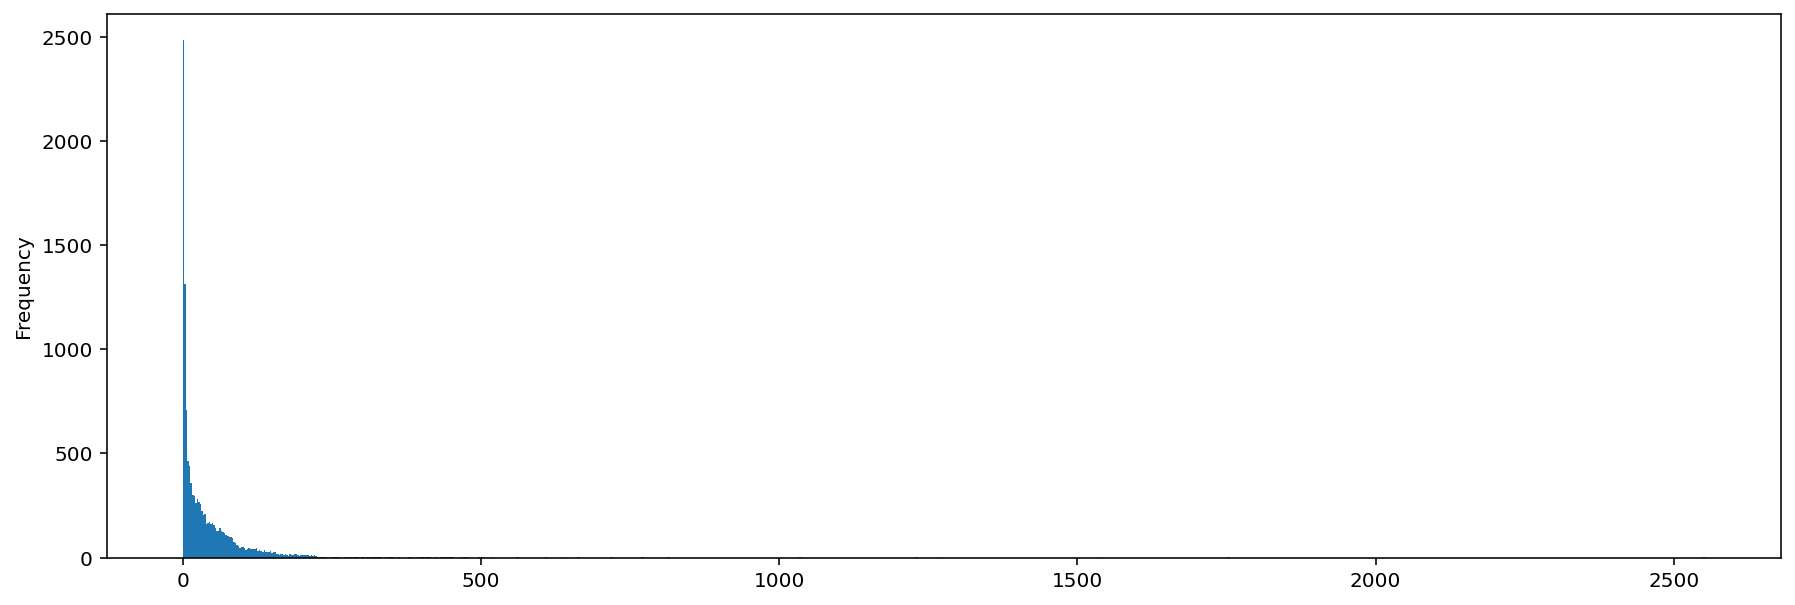

In [63]:
rests['offset'].astype(float).plot(kind='hist',bins=1000,x='offset',figsize=(15,5))

In [14]:
rests['fullName'].unique()

array(['Half tied to Eighth (2 1/2 total QL) Rest',
       '16th Triplet (1/6 QL) Rest', '32nd Triplet (1/12 QL) Rest',
       '16th Rest',
       'Breve tied to Whole tied to Dotted Quarter (13 1/2 total QL) Rest',
       'Duplex-Maxima Tuplet of 768/409ths (34 1/12 QL) Rest',
       'Eighth Tuplet of 6/5ths (5/12 QL) Rest', 'Dotted Half Rest',
       'Breve tied to Half tied to Dotted Eighth (10 3/4 total QL) Rest',
       'Inexpressible Rest', 'Eighth Rest',
       'Whole Tuplet of 48/37ths (3 1/12 QL) Rest',
       'Eighth Triplet (1/3 QL) Rest', 'Quarter Triplet (2/3 QL) Rest',
       'Quarter Rest',
       'Imperfect Longa tied to Whole tied to Eighth (20 1/2 total QL) Rest',
       'Half tied to 16th (2 1/4 total QL) Rest', 'Half Rest',
       'Dotted Eighth Rest', 'Double Dotted Quarter Rest',
       'Half Triplet (1 1/3 QL) Rest',
       'Breve tied to Dotted Quarter (9 1/2 total QL) Rest',
       'Quarter Tuplet of 12/7ths (7/12 QL) Rest',
       'Quarter Tuplet of 6/5ths (5/

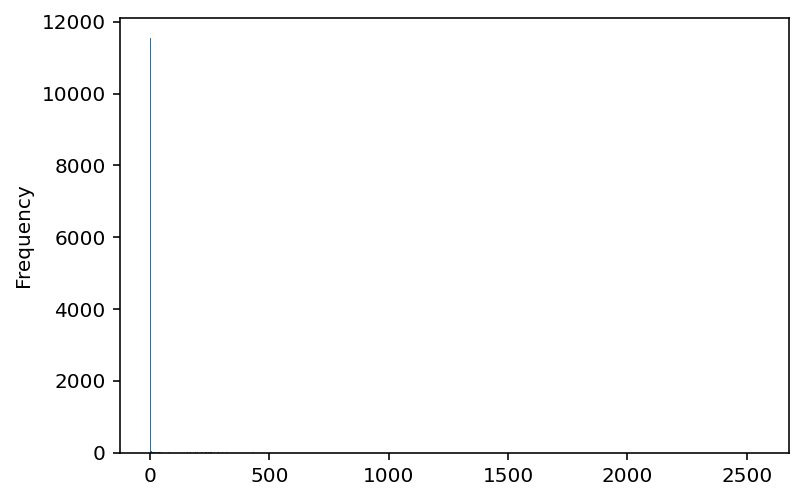

In [43]:
rests['duration'].map(lambda x: x.quarterLength).astype(float).plot(kind='hist',bins=1000)

In [132]:
rests['duration'].map(lambda x: x.quarterLength).unique()

array([2.5, Fraction(1, 6), Fraction(1, 12), 0.25, 13.5,
       Fraction(409, 12), Fraction(5, 12), 3.0, 10.75, 433.0, 0.5,
       Fraction(37, 12), Fraction(1, 3), Fraction(2, 3), 332.25, 1.0,
       332.0, 20.5, 2.25, 132.75, 2.0, 0.75, 1.75, Fraction(4, 3),
       Fraction(1373, 12), 9.5, Fraction(7, 12), Fraction(5, 6),
       Fraction(16, 3), 17.0, Fraction(1435, 3), Fraction(37, 3), 2.75,
       6.25, Fraction(13, 12), 1.5, Fraction(3041, 12), Fraction(5, 3),
       Fraction(1168, 3), 156.75, Fraction(1415, 6), 5.5, 8.5,
       Fraction(3425, 12), 4.75, 301.0, 6.0, 340.25, 5.75, 157.75, 75.25,
       1.25, 3.5, 235.5, 3.25, 100.0, 131.0, Fraction(67, 12),
       Fraction(20, 3), Fraction(457, 3), Fraction(11, 3), 4.0, 398.5,
       4.25, Fraction(74, 3), Fraction(1073, 3), Fraction(257, 12),
       Fraction(10, 3), Fraction(298, 3), Fraction(5045, 12), 11.5,
       Fraction(17, 12), 5.0, 1226.5, Fraction(7963, 12), 7.75, 10.5,
       652.25, Fraction(115, 12), Fraction(7, 3), Fra

In [48]:
rests['beat'].unique()

array([1.0, 3.5, Fraction(11, 3), 3.75, 4.0, 4.25, 2.5, Fraction(55, 12),
       4.75, 1.25, Fraction(23, 12), 2.25, Fraction(31, 12), 3.25,
       Fraction(43, 12), Fraction(47, 12), Fraction(19, 12), 2.75, 1.75,
       Fraction(35, 12), Fraction(59, 12), 4.5, 1.5, 2.0, Fraction(13, 3),
       Fraction(14, 3), 3.0, Fraction(8, 3), Fraction(4, 3),
       Fraction(10, 3), Fraction(5, 3), Fraction(7, 3), Fraction(11, 6),
       Fraction(37, 18), Fraction(17, 6), Fraction(7, 6), Fraction(11, 9),
       Fraction(49, 18), Fraction(25, 18), Fraction(29, 18),
       Fraction(49, 12), Fraction(29, 6), Fraction(13, 6),
       Fraction(23, 9), Fraction(17, 9), Fraction(25, 9), Fraction(19, 9),
       5.75, Fraction(23, 6), Fraction(37, 12)], dtype=object)

In [59]:
rests['beatDuration'].map(lambda x: x.quarterLength).unique()

array([1. , 1.5, 0.5])

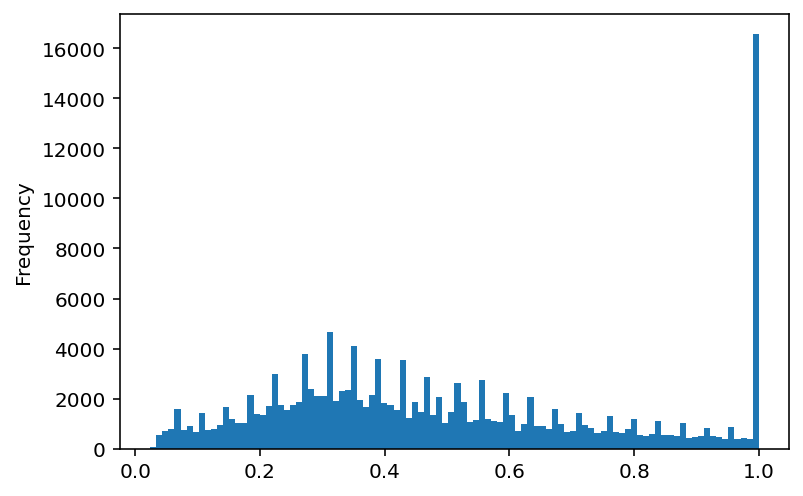

In [61]:
notes['volume'].map(lambda x: x.realized).plot(kind='hist',bins=100)

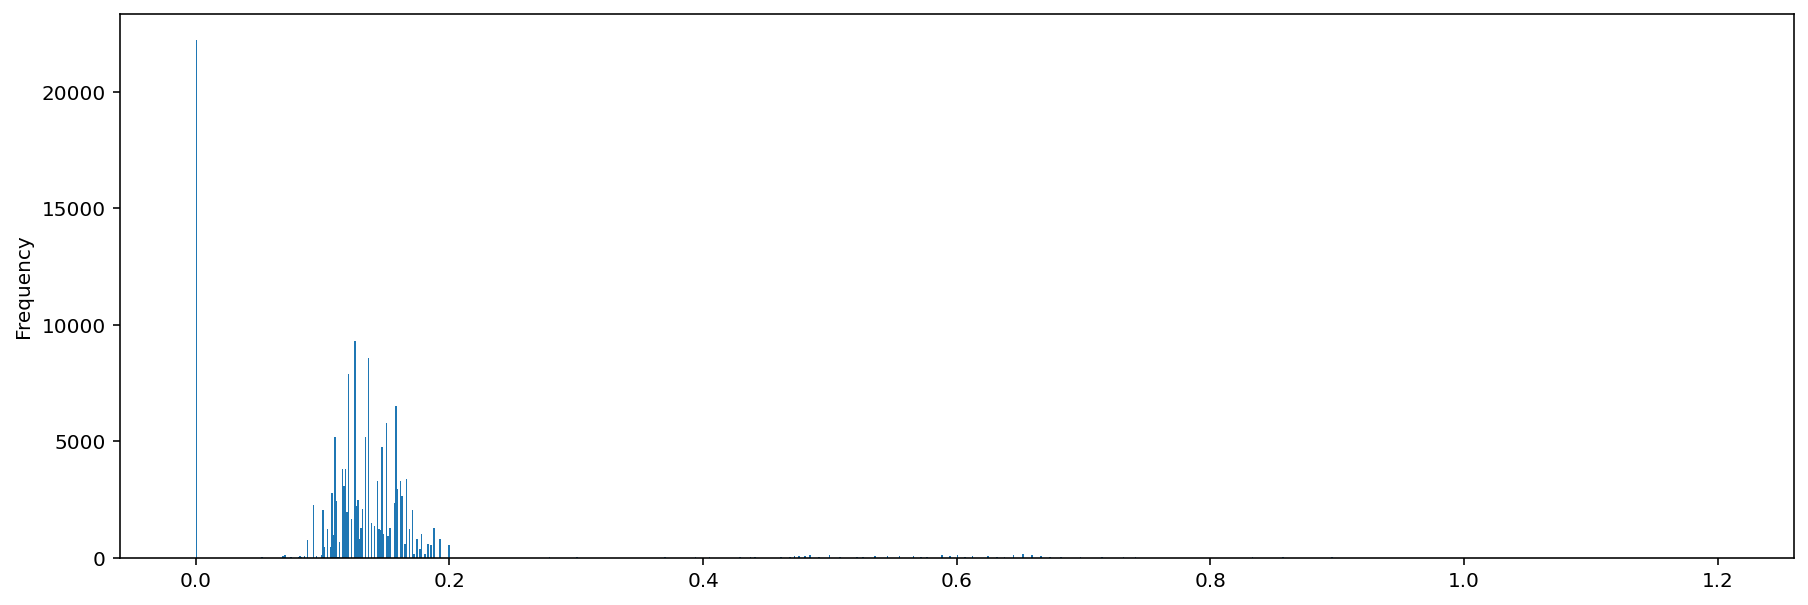

In [62]:
notes['seconds'].plot(kind='hist',bins=1000,x='seconds',figsize=(15,5))

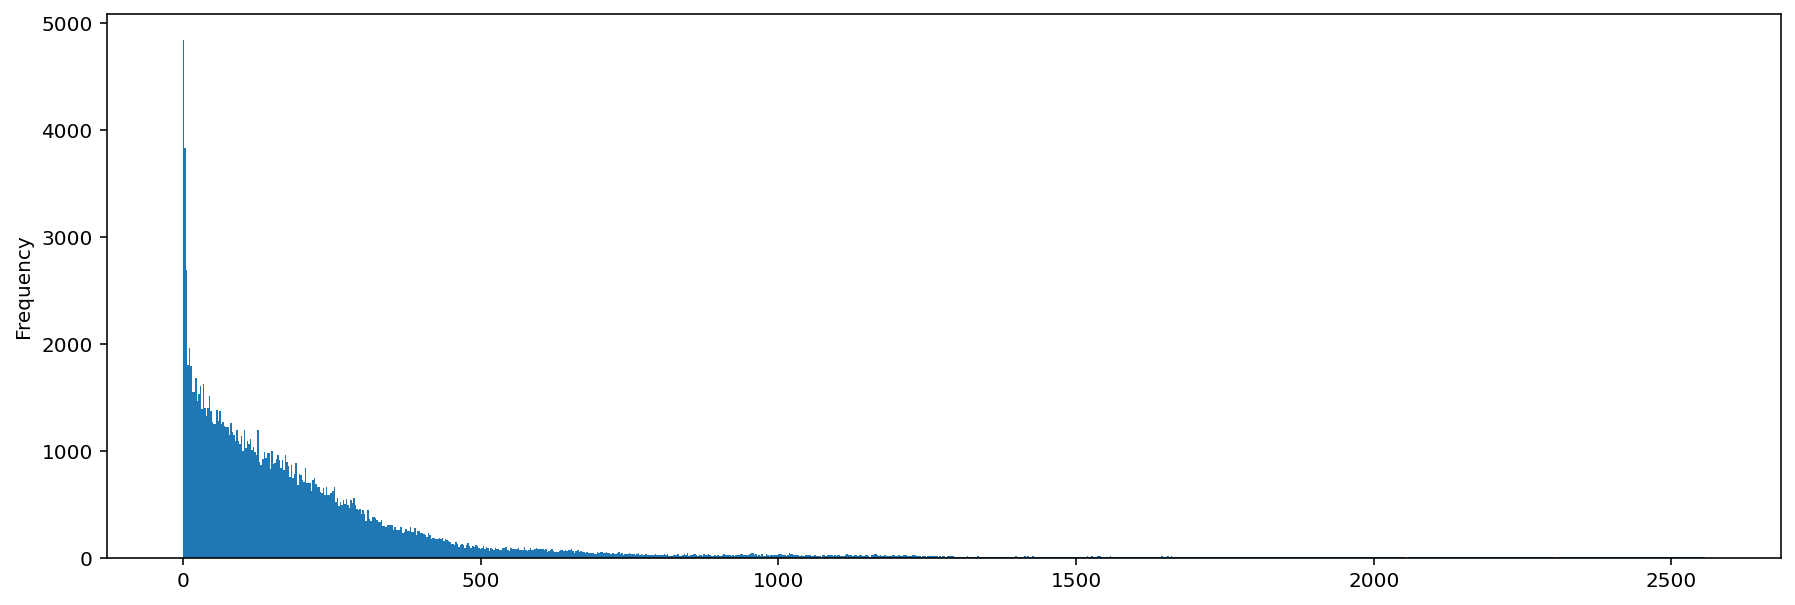

In [64]:
notes['offset'].astype(float).plot(kind='hist',bins=1000,x='offset',figsize=(15,5))

In [65]:
notes['fullName'].unique()

array(['D in octave 2 16th Note', 'D in octave 2 Zero Note',
       'G in octave 3 16th Note', 'C in octave 2 16th Note',
       'C in octave 2 Zero Note', 'A in octave 2 Zero Note',
       'G in octave 2 Zero Note', 'E-flat in octave 3 16th Note',
       'E in octave 2 16th Note', 'D in octave 2 Quarter Note',
       'B in octave 3 16th Note', 'C-sharp in octave 2 16th Note',
       'C in octave 3 16th Note', 'G-sharp in octave 2 16th Note',
       'F in octave 3 16th Note', 'F-sharp in octave 2 16th Note',
       'B-flat in octave 0 16th Note', 'B-flat in octave 0 Zero Note',
       'D in octave 1 16th Note', 'B-flat in octave 0 Quarter Note',
       'G in octave 2 16th Note', 'B-flat in octave 2 16th Note',
       'A in octave 2 16th Note', 'D in octave 3 16th Note',
       'E-flat in octave 3 Zero Note', 'B-flat in octave 3 16th Note',
       'E in octave 2 Zero Note', 'C in octave 2 Quarter Note',
       'C in octave 3 Zero Note', 'B in octave 2 16th Note',
       'C-sharp in octa

In [90]:
notes['fullName'].map(lambda x: x.split()[0]+x.split()[3]).unique()

array(['D2', 'G3', 'C2', 'A2', 'G2', 'E-flat3', 'E2', 'B3', 'C-sharp2',
       'C3', 'G-sharp2', 'F3', 'F-sharp2', 'B-flat0', 'D1', 'B-flat2',
       'D3', 'B-flat3', 'B2', 'C-sharp3', 'E3', 'A3'], dtype=object)

pitch : ['D2', 'G3', 'C2', 'A2', 'G2', 'E-flat3', 'E2', 'B3', 'C-sharp2', 'C3', 'G-sharp2', 'F3', 'F-sharp2', 'B-flat0', 'D1', 'B-flat2', 'D3', 'B-flat3', 'B2', 'C-sharp3', 'E3', 'A3']

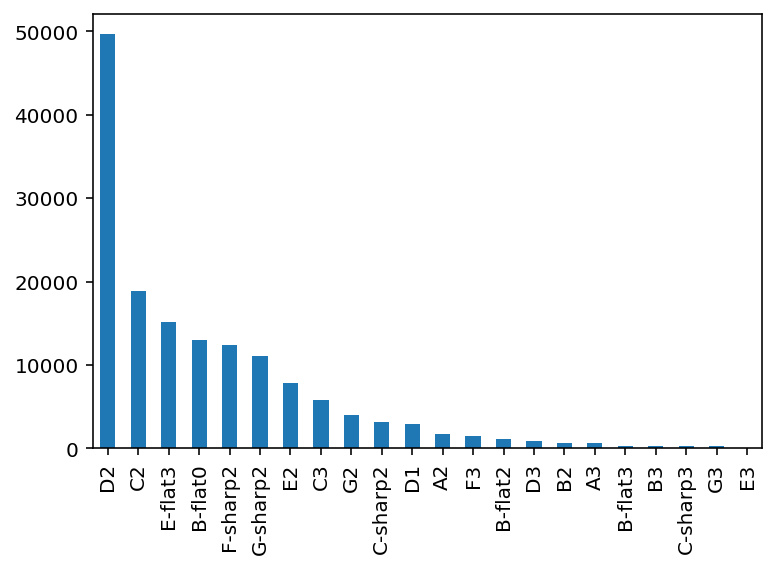

In [165]:
notes['fullName'].map(lambda x: x.split()[0]+x.split()[3]).value_counts().plot(kind='bar')

In [ ]:
pitch_conv={
    'B-flat0':(22,'IDK1'),
    'D1':(26,'IDK2'),
    'C2':(36,'Bass Drum 1'),
    'C-sharp2':(37,'Side Stick'),
    'D2':(38,'Acoustic Snare'),
    'E2':(40,'Electric Snare'),
    'F-sharp2':(42,'Closed Hi-Hat'),
    'G2':(43,'High Floor Tom'),
    'G-sharp2':(44,'Pedal Hi-Hat'),
    'A2':(45,'Low Tom'),
    'B-flat2':(46,'Open Hi-Hat'),
    'B2':(47,'Low-Mid Tom'),
    'C3':(48,'Hi-Mid Tom'),
    'C-sharp3':(49,'Crash Cymbal 1'),
    'D3':(50,'High Tom'),
    'E-flat3':(51,'Ride Cymbal 1'),
    'E3':(52,'Chinese Cymbal'),
    'F3':(53,'Ride Bell'),
    'G3':(55,'Splash Cymbal'),
    'A3':(57,'Crash Cymbal 2'),
    'B-flat3':(58,'Vibraslap'),
    'B3':(59,'Ride Cymbal 2')
}

In [67]:
notes['duration'].map(lambda x: x.quarterLength).astype(float).unique()

array([0.25      , 0.        , 1.        , 0.5       , 0.33333333,
       1.75      ])

In [71]:
notes['beat'].unique()

array([1.5, Fraction(7, 3), 2.5, 3.0, 4.0, 4.75, 3.5, Fraction(11, 3),
       3.75, 4.25, 4.5, 2.75, 1.75, 2.0, 3.25, 1.25, Fraction(13, 3),
       Fraction(4, 3), Fraction(10, 3), 2.25, Fraction(5, 3), 1.0,
       Fraction(8, 3), Fraction(14, 3), Fraction(11, 9), Fraction(17, 9),
       Fraction(13, 6), Fraction(23, 9), Fraction(17, 6), Fraction(19, 9),
       Fraction(25, 9), Fraction(7, 6), Fraction(11, 6), Fraction(13, 9),
       5.0, Fraction(16, 3), 5.5, Fraction(17, 3), 5.25, 5.75],
      dtype=object)

In [73]:
notes['beatDuration'].map(lambda x: x.quarterLength).unique()

array([1. , 1.5, 0.5])

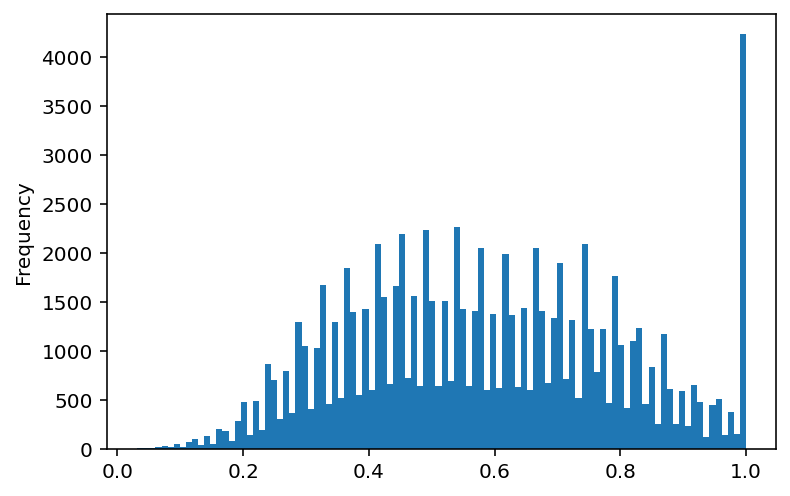

In [75]:
chords['volume'].map(lambda x: x.realized).plot(kind='hist',bins=100)

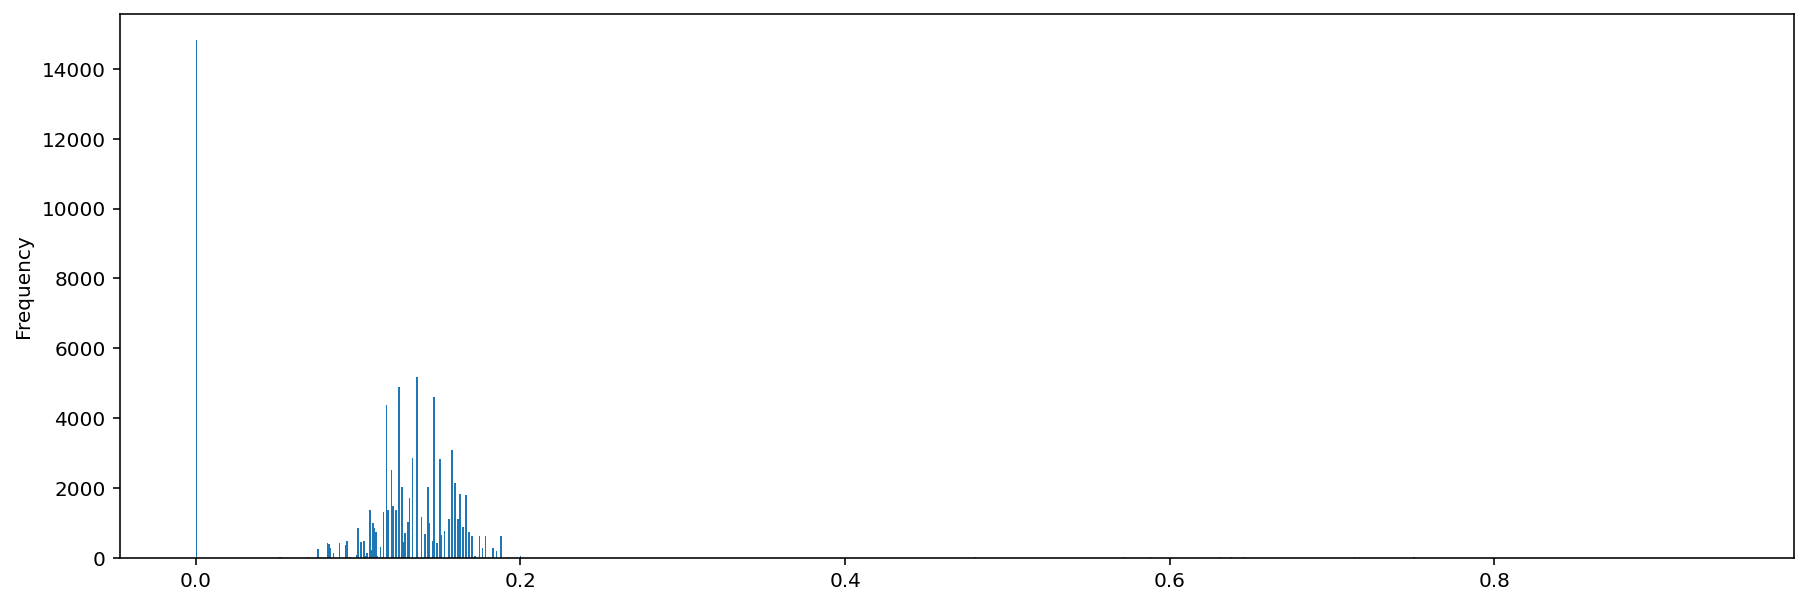

In [76]:
chords['seconds'].plot(kind='hist',bins=1000,x='seconds',figsize=(15,5))

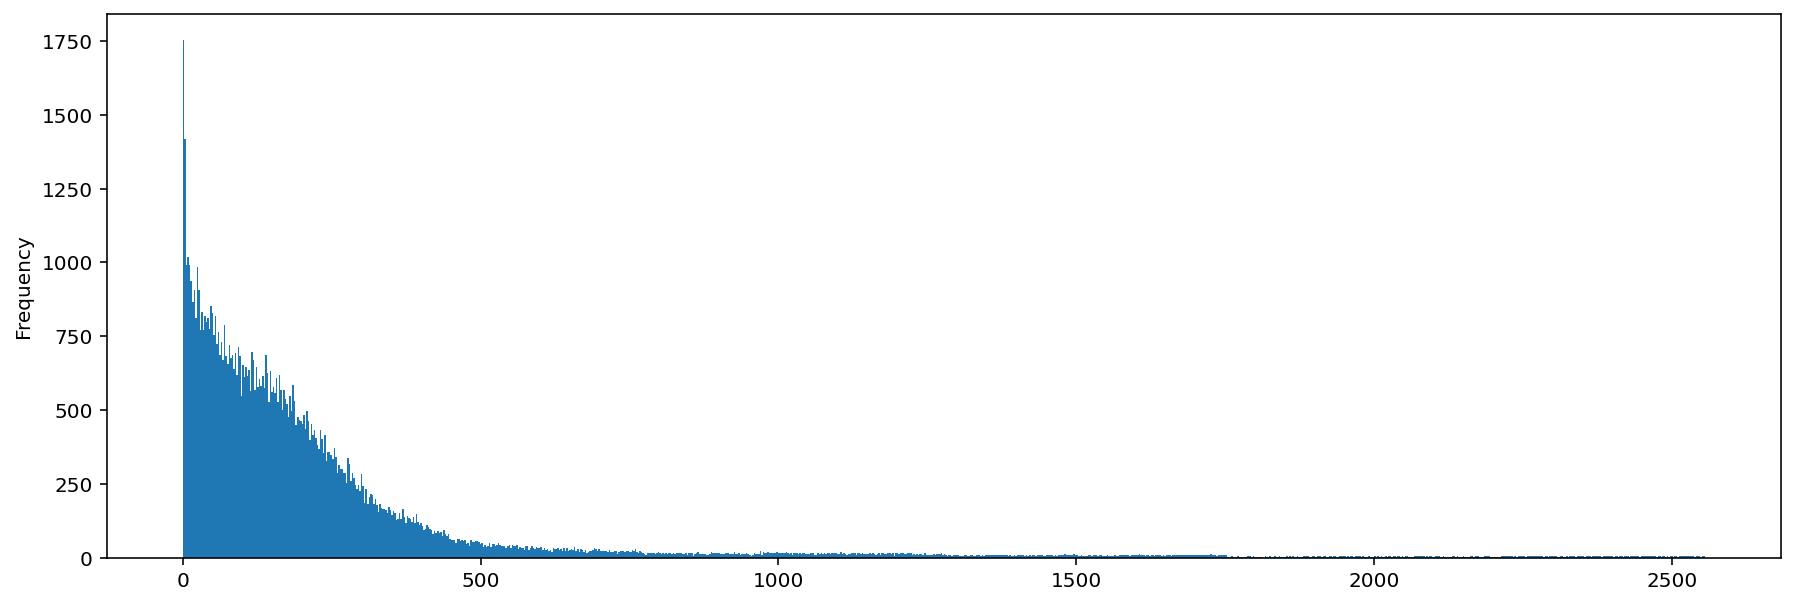

In [70]:
chords['offset'].astype(float).plot(kind='hist',bins=1000,x='offset',figsize=(15,5))

In [69]:
chords['fullName'].unique()

array(['Chord {C in octave 2 | G in octave 3} 16th',
       'Chord {G in octave 3 | C in octave 2} 16th',
       'Chord {B in octave 3 | C in octave 2} 16th', ...,
       'Chord {C in octave 2 | E-flat in octave 3 | E in octave 3} Zero',
       'Chord {G in octave 3 | E in octave 3 | C in octave 2} 16th',
       'Chord {E in octave 3 | G in octave 3 | C in octave 2} 16th'],
      dtype=object)

In [68]:
chords['duration'].map(lambda x: x.quarterLength).astype(float).unique()

array([0.25      , 0.        , 0.5       , 0.33333333, 1.        ])

In [72]:
chords['beat'].unique()

array([1.0, 1.75, Fraction(10, 3), 4.25, 1.5, 2.0, 3.0, 3.5, 4.5,
       Fraction(7, 3), 4.0, 2.5, 2.75, 3.75, 4.75, Fraction(13, 3),
       Fraction(4, 3), 3.25, 2.25, Fraction(8, 3), Fraction(5, 3),
       Fraction(14, 3), Fraction(11, 3), 1.25, Fraction(13, 6),
       Fraction(17, 6), Fraction(17, 9), Fraction(19, 9), 5.0,
       Fraction(17, 3), Fraction(11, 9), Fraction(23, 9), 5.25, 5.75, 5.5,
       Fraction(16, 3)], dtype=object)

In [74]:
chords['beatDuration'].map(lambda x: x.quarterLength).unique()

array([1. , 1.5, 0.5])

In [133]:
chords

,volume,seconds,offset,fullName,duration,beat,beatDuration
0,<music21.volume.Volume realized=0.77>,0.125000,0.0,Chord {C in octave 2 | G in octave 3} 16th,<music21.duration.Duration 0.25>,1.0,<music21.duration.Duration 1.0>
1,<music21.volume.Volume realized=0.81>,0.125000,0.75,Chord {G in octave 3 | C in octave 2} 16th,<music21.duration.Duration 0.25>,1.75,<music21.duration.Duration 1.0>
2,<music21.volume.Volume realized=0.75>,0.125000,4.0,Chord {C in octave 2 | G in octave 3} 16th,<music21.duration.Duration 0.25>,1.0,<music21.duration.Duration 1.0>
3,<music21.volume.Volume realized=0.76>,0.125000,4.75,Chord {G in octave 3 | C in octave 2} 16th,<music21.duration.Duration 0.25>,1.75,<music21.duration.Duration 1.0>
4,<music21.volume.Volume realized=0.86>,0.125000,19/3,Chord {G in octave 3 | C in octave 2} 16th,<music21.duration.Duration 0.25>,10/3,<music21.duration.Duration 1.0>
...,...,...,...,...,...,...,...
85905,<music21.volume.Volume realized=0.84>,0.163043,20.0,Chord {C in octave 2 | G in octave 3 | E in oc...,<music21.duration.Duration 0.25>,1.0,<music21.duration.Duration 1.0>
85906,<music21.volume.Volume realized=0.89>,0.163043,22.0,Chord {C in octave 2 | E-flat in octave 3} 16th,<music21.duration.Duration 0.25>,3.0,<music21.duration.Duration 1.0>
85907,<music21.volume.Volume realized=0.7>,0.000000,0.0,Chord {C in octave 2 | B-flat in octave 0} Zero,<music21.duration.Duration 0.0>,1.0,<music21.duration.Duration 1.0>
85908,<music21.volume.Volume realized=0.35>,0.000000,0.25,Chord {F-sharp in octave 2 | F-sharp in octave...,<music21.duration.Duration 0.0>,1.25,<music21.duration.Duration 1.0>


- 리스트 안에 오브젝트를 넣으면 계산이 느려집니다.
- volume : 강세라고 생각됩니다. 학습하면 좋겠지만 복잡해지므로 1로 두겠습니다.
- seconds : 무시해도 될 것이라 생각합니다.
- offset : 무시하고 미디파일을 생성할 때 첫 노트만 1초로 하면 될 것이라 생각합니다.
- fullName : 박자와 피치가 담긴 것으로 보입니다. 
- duration, beat, beatDuration : 모든 beat를 정수로 나눌 수 있는 수를 최소 단위로 사용하면 될 것이라 생각합니다. 최소 단위는 beat를 기준으로 1/36을 사용하겠습니다.